Import Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from os.path import exists
from os import remove
from methods.method1.spei_calc_multi import *

## Load netCDF files
Loading a netCDF file which contains the averaged monthly temperature and another netCDF file which contains the precipitation sum for a month as an `xarray.DataArray`.

In [2]:
# Open the netCDF files
day = 1
time_scale = 3
date_target = datetime(2014, 5, day)
date_begin = date_target - relativedelta(months=time_scale-1)
date_end = date_target 
save = False

print(date_begin)
print(date_end)

# Precipitation
prec_file_paths = generate_imerg_filenames(
    date_begin, date_end, "/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/")
# Temperature
temp_file_paths = generate_t2m_filenames(
    date_begin, date_end, "/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/")

print(prec_file_paths)
print(temp_file_paths)
len(prec_file_paths) == len(temp_file_paths)

2014-03-01 00:00:00
2014-05-01 00:00:00
['/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140301-S000000-E235959.03.V07B.HDF5.nc4', '/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140401-S000000-E235959.04.V07B.HDF5.nc4', '/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.20140501-S000000-E235959.05.V07B.HDF5.nc4']
['/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201403.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201404.nc', '/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_201405.nc']


True

In [3]:
prec_ds = xr.open_mfdataset(prec_file_paths)
temp_ds = xr.open_mfdataset(temp_file_paths)

# prec_ds['time'] = prec_ds['time'].astype('datetime64[ns]')
# temp_ds['time'] = temp_ds['time'].astype('datetime64[ns]')

In [4]:
prec_ds

<xarray.Dataset> Size: 389MB
Dimensions:                         (time: 3, lon: 3600, lat: 1800, latv: 2,
                                     nv: 2, lonv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) object 24B 2014-03-01 00:00:00 ......
Data variables:
    precipitationQualityIndex       (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 43kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
    precipitation                   (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 86kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:15:58 GMT Hyrax-1.16.3 htt...

In [5]:
temp_ds

<xarray.Dataset> Size: 156MB
Dimensions:    (time: 3, longitude: 3600, latitude: 1801, expver: 2)
Coordinates:
  * time       (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * expver     (expver) int32 8B 1 5
Data variables:
    t2m        (time, expver, latitude, longitude) float32 156MB dask.array<chunksize=(1, 2, 1801, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Data preprocessing

### Preprocessing: Precipitation dataset

In [6]:
# Rearrange the dimensions of the precipitation xarray.DataArray
prec_ds = preprocess_prec(prec_ds)
prec_ds

<xarray.Dataset> Size: 389MB
Dimensions:                         (time: 3, lat: 1800, lon: 3600, latv: 2,
                                     nv: 2, lonv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) datetime64[ns] 24B 2014-03-01 ... ...
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 43kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
    precipitation                   (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 78MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 86kB dask.array<chunksize=(1, 1024, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:15:58 GMT Hyrax-1.16.3 htt...

In [7]:
# Current datetime used for file name's suffix
dt = datetime.now()
dt_str = dt.strftime("%Y%m%d_%H%M%S")

### Preprocessing: Temperature dataset
The longitude of the **temperature netCDF file** has the range `0.00-180.00` which is why we convert the longitude to the range `-180.00-180.00`.

In [8]:
temp_ds = preprocess_temp(temp_ds)

In [9]:
# Show temperature DataArray
temp_ds

<xarray.Dataset> Size: 156MB
Dimensions:  (time: 3, lat: 1801, expver: 2, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * expver   (expver) int32 8B 1 5
  * lon      (lon) float32 14kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    t2m      (time, expver, lat, lon) float32 156MB dask.array<chunksize=(1, 2, 1801, 3600), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Select Germany as study area
For this study we use the latitude and longtitude bounds of the European country Germany.

**Lat:** 47.0, 55.0\
**Lon:** 5.5, 15.0

In [10]:
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

In [11]:
# Select the data for Germany
prec_germany = spatial_subset(ds=prec_ds, lat_bounds=lat_bounds, lon_bounds=lon_bounds)
temp_germany = spatial_subset(ds=temp_ds, lat_bounds=lat_bounds, lon_bounds=lon_bounds)


In [12]:
prec_germany

<xarray.Dataset> Size: 461kB
Dimensions:                         (time: 3, lat: 80, lon: 95, latv: 2, nv: 2,
                                     lonv: 2)
Coordinates:
  * lat                             (lat) float32 320B 47.05 47.15 ... 54.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 380B 5.55 5.65 ... 14.85 14.95
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) datetime64[ns] 24B 2014-03-01 ... ...
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    gaugeRelativeWeighting          (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    lat_bnds                        (time, lat, latv) float32 2kB dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    precipitation                   (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 91kB dask.array<chunksize=(1, 80, 95), meta=np.ndarray>
    time_bnds                       (time, nv) object 48B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds                        (time, lon, lonv) float32 2kB dask.array<chunksize=(1, 95, 2), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:15:58 GMT Hyrax-1.16.3 htt...

In [13]:
temp_germany

<xarray.Dataset> Size: 187kB
Dimensions:  (time: 3, lat: 81, expver: 2, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
  * lat      (lat) float32 324B 47.0 47.1 47.2 47.3 47.4 ... 54.7 54.8 54.9 55.0
  * expver   (expver) int32 8B 1 5
  * lon      (lon) float32 384B 5.5 5.6 5.7 5.8 5.9 ... 14.6 14.7 14.8 14.9 15.0
Data variables:
    t2m      (time, expver, lat, lon) float32 187kB dask.array<chunksize=(1, 2, 81, 96), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

## Calculate PET

In [14]:
pet_germany = calc_pet_thornthwaite(temp_germany, time_scale)
if save:
    save_as_nc(pet_germany, f"output/pet_germany_multi_{dt_str}.nc")

In [15]:
pet_germany

<xarray.DataArray (time: 3, expver: 2, lat: 81, lon: 96, month: 3)> Size: 1MB
dask.array<mul, shape=(3, 2, 81, 96, 3), dtype=float64, chunksize=(1, 2, 81, 96, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
  * lat      (lat) float32 324B 47.0 47.1 47.2 47.3 47.4 ... 54.7 54.8 54.9 55.0
  * expver   (expver) int32 8B 1 5
  * lon      (lon) float32 384B 5.5 5.6 5.7 5.8 5.9 ... 14.6 14.7 14.8 14.9 15.0
  * month    (month) int64 24B 3 4 5

In [16]:
pet_germany, prec_germany = preprocess_pet(pet_germany, prec_germany)

In [17]:
print(prec_germany.shape)
print(pet_germany.shape)
print(prec_germany.dims)
print(pet_germany.dims)
print(prec_germany.coords)
print(pet_germany.coords)

(3, 80, 95)
(3, 80, 95, 3)
('time', 'lat', 'lon')
('time', 'lat', 'lon', 'month')
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
Coordinates:
    expver   int32 4B 1
  * month    (month) int64 24B 3 4 5
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95


In [18]:
difference = calc_difference(prec_germany, pet_germany, time_scale)
if save:
    save_as_nc(difference, f"output/diff_germany_multi_{dt_str}.nc")
difference

<xarray.DataArray (time: 3, lat: 80, lon: 95, month: 3)> Size: 547kB
dask.array<sub, shape=(3, 80, 95, 3), dtype=float64, chunksize=(1, 80, 95, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
    expver   int32 4B 1
  * month    (month) int64 24B 3 4 5

In [19]:
cdf_vals = calc_cdf_values(difference)
cdf_vals

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<xarray.DataArray (time: 3, lat: 80, lon: 95, month: 3)> Size: 547kB
array([[[[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
...
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]],

        [[           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan],
         [           nan,            nan,            nan],
         [           nan,            nan,            nan]]]])
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
    expver   int32 4B 1
  * month    (month) int64 24B 3 4 5

In [20]:
spei = create_spei_ds(difference, cdf_vals)
spei

<xarray.DataArray (time: 3, lat: 80, lon: 95, month: 3)> Size: 547kB
array([[[[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
...
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]])
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 24B 2014-03-01 2014-04-01 2014-05-01
    expver   int32 4B 1
  * month    (month) int64 24B 3 4 5

This is the SPEI diagram which shows the SPEI values.
The indices should be interpreted as such:

| Range of Values   | Regime            |
|-------------------|-------------------|
| 2 < SPEI <= MAX     | Extremely Wet     |
| 1.5 < SPEI <= 2.0   | Very Wet          |
| 1.0 < SPEI <=1.5    | Moderately Wet    |
| -1.0 < SPEI <= 1.0  | Normal Conditions |
| -1.5 < SPEI <= -1.0 | Moderately Dry    |
| -2.0 < SPEI <= -1.5 | Very Dry          |
| MIN <= SPEI <= -2.0 | Extremely Dry     |

(3, 80, 95, 3)
4
(3, 80, 95, 3)


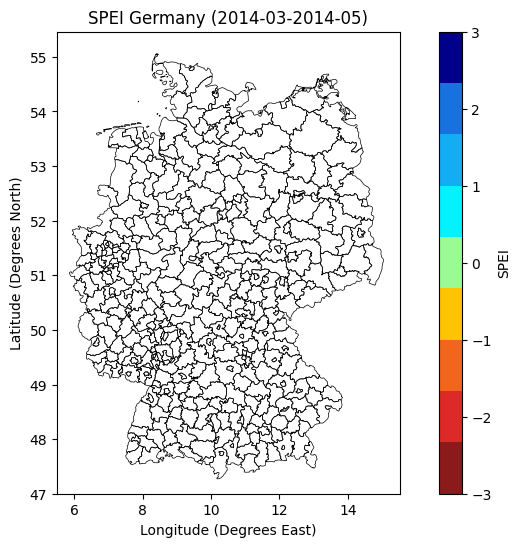

In [21]:
shape_file_path = '/home/jtrvz/Downloads/vg2500_geo84/vg2500_krs.shp'
spei_plot(spei, shape_file_path, lon_bounds, lat_bounds,
          f"SPEI Germany ({date_begin.strftime('%Y-%m')}-{date_end.strftime('%Y-%m')})", "output/test-multi.png")

In [22]:
if save:
    save_as_nc(spei, f"output/spei_multi_{date_begin.strftime('%Y%m')}-{date_end.strftime('%Y%m')}_{dt_str}.nc")